In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
from queue import PriorityQueue

## Simple functions from the first classes
This is left just as an example (to compare the behaviour).

In [2]:
def print_matrix(vertices, matrix):
    """
    Printing a graph given by adjacency matrix.
    Each row i shows vertices reachable from vertex i.
    """
    n = len(matrix)

    # If vertex list is valid and matches matrix size, use it
    if (vertices is not None) and (len(vertices) == n):
        vv = vertices
    else:
        vv = range(1, n + 1)

    # Print adjacency structure
    for i in range(n):
        print(vv[i], ":", end="")
        for j in range(n):
            if matrix[i, j]:
                print(" ", vv[j], end="")
        print("")  # New line


def print_dict(graph):
    """
    Printing a graph given as a dictionary (neighbourhood list).
    """
    for v in graph:
        print(v, ":", end="")
        for u in graph[v]:
            print(" ", u, end="")
        print("")  # New line

## Class *Graph*

In [3]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices=None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    @staticmethod
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts an adjacency matrix to a dictionary representation.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape=(n, n), dtype=int)

        for u, v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1

        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self):
        """
        Plots the graph using networkx package.
        Shows directed edges as arrows.
        """
        G = nx.DiGraph(self.graph)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, arrows=True)
        plt.show()

    # Saving
    def to_neighbourlist(self, filename: str):
        """
        Saves graph to a text file as a neighbour dict.
        """
        with open(filename, "w") as file:
            file.write(str(self))

    # Modyfying graphs
    def add_vertex(self, vertex):
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Directed graph: u -> v
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Undirected graph: symmetric edges u<->v.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from file
    @staticmethod
    def from_edges(filename: str, directed=0):
        graph = Graph()
        with open(filename, "r") as file:
            for line in file:
                words = line.strip().split()
                if len(words) == 1:
                    graph.add_vertex(words[0])
                elif len(words) >= 2:
                    if directed:
                        graph.add_arc([words[0], words[1]])
                    else:
                        graph.add_edge([words[0], words[1]])
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def random_bipartite_graph(m, n, p):
        bipartite_graph = Graph()
        for i in range(1, m + n + 1):
            bipartite_graph.add_vertex(i)
        for u in range(1, m + 1):
            for w in range(m + 1, m + n + 1):
                if random() < p:
                    bipartite_graph.add_edge([u, w])
        return bipartite_graph

    @staticmethod
    def cycle(n: int):
        cycle = Graph()
        for i in range(n - 1):
            cycle.add_edge([i + 1, i + 2])
        cycle.add_edge([1, n])
        return cycle

    def Prufer(self):
        tr = deepcopy(self.graph)
        code = ""
        for i in range(len(self.graph) - 2):
            for x in sorted(tr):
                if len(tr[x]) == 1: break
            v = tr[x][0]
            code += f"{v} "
            tr[v].remove(x)
            tr.pop(x)
        return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]
        n = len(clist) + 2
        vert = [*range(1, n + 1)]
        for v in vert:
            tree.add_vertex(v)
        for i in range(n - 2):
            for x in vert:
                if x not in clist:
                    break
            v = clist.pop(0)
            tree.add_edge((x, v))
            vert.remove(x)
        tree.add_edge(vert)
        return tree

    def connected_components(self):
        def DFS(u):
            for w in self.graph[u]:
                if w not in VT[0]:
                    VT[0].add(w)
                    VT[-1].add(w)
                    DFS(w)

        VT = [set([])]
        for v in self.graph:
            if v not in VT[0]:
                VT[0].add(v)
                VT.append(set([v]))
                DFS(v)
        return VT

    def preorder(self, v, visited=None):
        if visited is None:
            visited = set()
        if v not in visited:
            print(v, end=" ")
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.preorder(neighbor, visited)

    def postorder(self, v, visited=None):
        if visited is None:
            visited = set()
        if v not in visited:
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.postorder(neighbor, visited)
            print(v, end=" ")

    def InducedSubgraph(self, V):
        subgraph = Graph()
        for v in V:
            subgraph.add_vertex(v)
            for w in self.graph[v]:
                if w in V:
                    subgraph.add_arc([v, w])
        return subgraph

    def ConnectedComponentsGraphs(self):
        components_vertex_sets = self.connected_components()
        list_of_component_graphs = []

        for component_set in components_vertex_sets[1:]:
            component_graph = Graph()
            for u in component_set:
                component_graph.graph[u] = self.graph[u]
            list_of_component_graphs.append(component_graph)

        return list_of_component_graphs

    def distance(self, v):
        dist = {v: 0}
        queue = [v]
        while queue:
            u = queue.pop(0)
            for w in self.graph[u]:
                if w not in dist:
                    dist[w] = dist[u] + 1
                    queue.append(w)
        return dist

    def GeneralisedDFS(self):
        global timer

        def DFS(v):
            global timer
            visited[v] = timer
            for u in self.graph[v]:
                if u not in visited:
                    timer += 1
                    DFS(u)
            processed[v] = timer

        timer = 0
        visited = {}
        processed = {}

        for v in self.graph:
            if v not in visited:
                DFS(v)

        return visited, processed

    def TopologicalSort2(self):
        ordering = {}
        vis, pro = self.GeneralisedDFS()
        for v in self.graph:
            ordering[v] = pro[v] * len(self.graph) - vis[v]
        order = sorted(ordering, key=ordering.get, reverse=True)
        return ordering, order

## Class *WeightedGraph*

In [11]:
class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # redefinition of printing and plotting
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f'{v}: '
            for u in self.graph[v]:
                res += f'{u}({self.weights[(v, u)]}) '
            res += '\n'
        return res

    def plot(self):
        """
        Plots the graph using networkx package.
        """
        G = nx.Graph(self.graph)
        nx.set_edge_attributes(G, self.weights, 'weight')
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()
    
    def plot_digraph(self):
        """
        Plots the directed weighted graph using networkx package with arrows and edge weights.
        """
        G = nx.DiGraph(self.graph) 
        nx.set_edge_attributes(G, self.weights, 'weight')  
        pos = nx.spring_layout(G)  
        nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True, arrowsize=20)
        edge_labels = nx.get_edge_attributes(G, 'weight')  
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

    # Modifying graphs
    def del_vertex(self, v):
        """
        Removes a vertex from the graph.
        """
        super().del_vertex(v)

    def add_arc(self, arc, weight=1):
        """
        Given pair of vertices (arc variable) add an arc to the graph.
        We consider simple, directed graphs.
        """
        super().add_arc(arc)
        u, v = arc
        self.weights[(u, v)] = weight

    def add_edge(self, edge, weight=1):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs.
        """
        super().add_edge(edge)
        u, v = edge
        self.weights[(u, v)] = weight
        self.weights[(v, u)] = weight

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed=0):
        """
        Read the graph from file. Lines:
        - 1 word → vertex
        - 2 words → unweighted edge
        - ≥3 words → weighted edge (third word = weight)
        """
        graph = WeightedGraph()
        file = open(filename, "r")
        for line in file:
            words = line.strip().split()
            if len(words) == 1:
                graph.add_vertex(words[0])
            elif len(words) == 2:
                if directed:
                    graph.add_arc([words[0], words[1]])
                else:
                    graph.add_edge([words[0], words[1]])
            elif len(words) >= 3:
                if directed:
                    graph.add_arc([words[0], words[1]], int(words[2]))
                else:
                    graph.add_edge([words[0], words[1]], int(words[2]))
        file.close()
        return graph

    def min_spanning_tree(self):
        """
        Computes a minimum spanning tree using Jarnik - Prim's algorithm.
        """
        for v in self.graph:
            break
        wtree = WeightedGraph()
        wtree.add_vertex(v)
        total_weight = 0
        q = PriorityQueue()
        for w in self.graph[v]:
            q.put((self.weights[(v, w)], v, w))
        while not q.empty():
            weight, u, v = q.get()
            if v not in wtree.graph:
                wtree.add_edge([u, v], weight)
                total_weight += weight
                for w in self.graph[v]:
                    if w not in wtree.graph:
                        q.put((self.weights[(v, w)], v, w))
        if len(wtree.graph) != len(self.graph):
            print("The graph is not connected! Returned is a spanning tree of some component.")
        return total_weight, wtree

    def Dijkstra(self, s):
        """
        Computes shortest paths from s using Dijkstra.
        Returns dictionary of distances and predecessors.
        """
        dist = {}
        pred = {}
        for v in self.graph:
            dist[v] = float('inf')
            pred[v] = None
        dist[s] = 0

        queue = PriorityQueue()
        queue.put((0, s))

        while not queue.empty():
            d, u = queue.get()
            if dist[u] < d:
                continue
            for v in self.graph[u]:
                if dist[v] > dist[u] + self.weights[(u, v)]:
                    dist[v] = dist[u] + self.weights[(u, v)]
                    pred[v] = u
                    queue.put((dist[v], v))

        return dist, pred
    
    
    """Task 6: 1. Implement the Bellman-Ford algorithm with an additional check 
    for the existence of a negative-weight cycle."""
    
    def BellmanFord(self, s):
        """
        Bellman–Ford algorithm. Computes shortest paths from source s and detects negative-weight cycles.
        """
        dist = {v: float('inf') for v in self.graph} # all distances start as +∞
        pred = {v: None for v in self.graph} # predecessor dictionary
        dist[s] = 0
        vertices = list(self.graph.keys())
        n = len(vertices)
        for _ in range(n - 1): # relax all edges|V|-1 times
            updated = False 
            for u in self.graph: # iterate over all edges u → v
                for v in self.graph[u]:
                    w = self.weights[(u, v)] # weight
                    if dist[u] + w < dist[v]: # relaxation condition (better path)
                        dist[v] = dist[u] + w  
                        pred[v] = u             
                        updated = True # update happened
            if not updated:
                break 

        has_negative_cycle = False # check for negative-weight cycles
        for u in self.graph: # scan all edges again
            for v in self.graph[u]:
                w = self.weights[(u, v)]
                if dist[u] + w < dist[v]: # if further relaxation is possible → negative cycle exists
                    has_negative_cycle = True

        return dist, pred, has_negative_cycle
    
    """Task 6: 2. For the Floyd-Warshall algorithm (already implemented) - improve it by adding 
    information about the penultimate vertex on the shortest path."""
    
    def FloydWarshall_WithPredecessor(self):
        """
        Computes shortest paths between all pairs of vertices using Floyd-Warshall algorithm.
        """
        vertices = self.vertices()                     
        n = len(vertices)
        index = {v: i for i, v in enumerate(vertices)} # index in matrices
        dist = np.full((n, n), np.inf) # distance matrix
        pred = np.full((n, n), None) # predecessor/penultimate matrix
        for i in range(n):
            dist[i, i] = 0 # distance to self
        for u in vertices:
            for v in self.graph[u]:
                dist[index[u], index[v]] = self.weights[(u, v)]   # edge weight 
                pred[index[u], index[v]] = u # u is the penultimate vertex to reach v from u

        # Floyd-Warshall algorithm 
        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i, j] > dist[i, k] + dist[k, j]: # check if going through k improves distance
                        dist[i, j] = dist[i, k] + dist[k, j] # update distance
                        pred[i, j] = pred[k, j] # update penultimate vertex

        return dist, pred  

### Example usage of Bellman-Ford algorithm

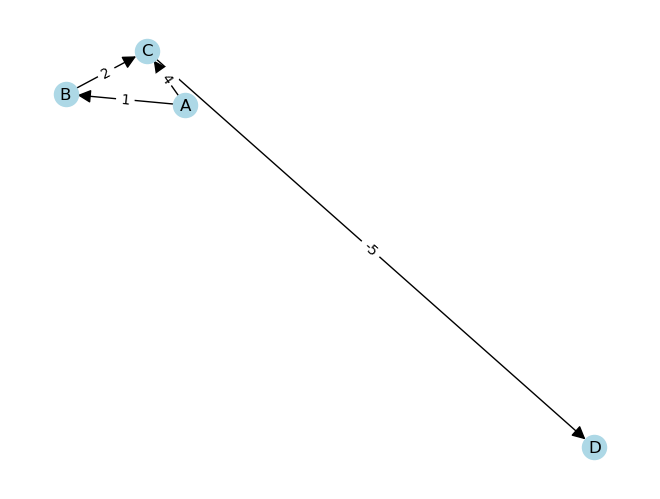

Distances: {'A': 0, 'B': 1, 'C': 3, 'D': -2}
Predecessors: {'A': None, 'B': 'A', 'C': 'B', 'D': 'C'}
Negative cycle? False


In [12]:
# No negative cycle

g = WeightedGraph()

for v in ["A", "B", "C", "D"]:
    g.add_vertex(v)

g.add_arc(["A", "B"], 1)
g.add_arc(["B", "C"], 2)
g.add_arc(["A", "C"], 4)
g.add_arc(["C", "D"], -5)

g.plot_digraph()

dist, pred, neg = g.BellmanFord("A")

print("Distances:", dist)
print("Predecessors:", pred)
print("Negative cycle?", neg)

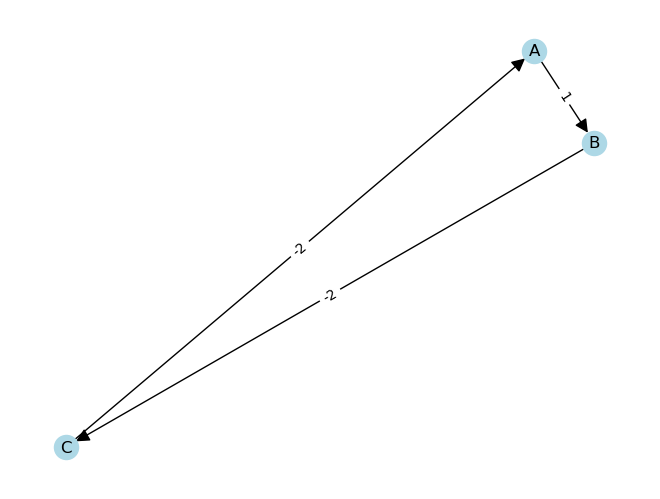

Distances: {'A': -6, 'B': -2, 'C': -4}
Predecessors: {'A': 'C', 'B': 'A', 'C': 'B'}
Negative cycle? True


In [13]:
# Negative cycle

g = WeightedGraph()

for v in ["A", "B", "C"]:
    g.add_vertex(v)

g.add_arc(["A", "B"], 1)
g.add_arc(["B", "C"], -2)
g.add_arc(["C", "A"], -2)  # negative cycle: A → B → C → A

g.plot_digraph()

dist, pred, neg = g.BellmanFord("A")

print("Distances:", dist)
print("Predecessors:", pred)
print("Negative cycle?", neg)

### Example usage of Floyd-Warshall (with penultimate vertex)

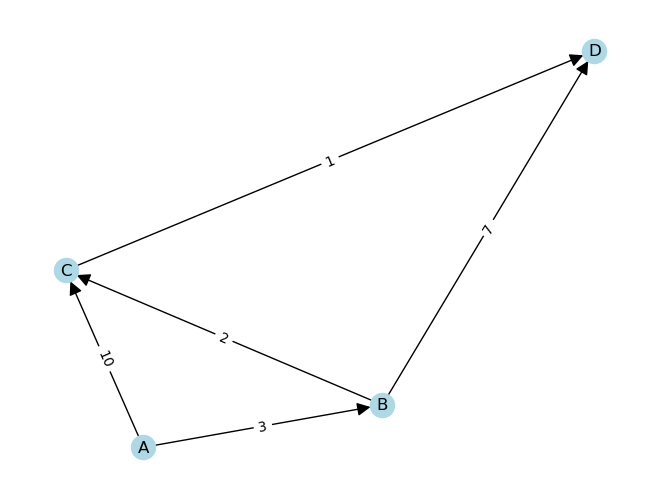

Distance matrix:
  0.0   3.0   5.0   6.0 
  inf   0.0   2.0   3.0 
  inf   inf   0.0   1.0 
  inf   inf   inf   0.0 

Predecessor (penultimate) matrix:
None A B C 
None None B C 
None None None C 
None None None None 


In [16]:
g = WeightedGraph()

for v in ["A", "B", "C", "D"]:
    g.add_vertex(v)

g.add_arc(["A", "B"], 3)
g.add_arc(["B", "C"], 2)
g.add_arc(["A", "C"], 10)
g.add_arc(["C", "D"], 1)
g.add_arc(["B", "D"], 7)

g.plot_digraph()

dist_matrix, pred_matrix = g.FloydWarshall_WithPredecessor()

print("Distance matrix:")
vertices = g.vertices()
for i, u in enumerate(vertices):
    for j, v in enumerate(vertices):
        print(f"{dist_matrix[i, j]:5}", end=" ")
    print()

print("\nPredecessor (penultimate) matrix:")
for i, u in enumerate(vertices):
    for j, v in enumerate(vertices):
        print(f"{pred_matrix[i, j]}", end=" ")
    print()
    
# predecessor is the vertex immediately before the destination on the shortest path